# Problem description

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

## Definition of churn

There are two main models of payment in the telecom industry - postpaid (customers pay a monthly/annual bill after using the services) and prepaid (customers pay/recharge with a certain amount in advance and then use the services).

In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

## Goal of the analysis
 

Define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

#### Import libraries and load datafile

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Until fuction: line seperator
def print_ln():
    print('-'*80, '\n')
    
pd.options.display.float_format = '{:.2f}'.format

# Load csv data file
telecom_orig = pd.read_csv('../data/raw/telecom_churn_data.csv', low_memory=False)

#### Checking the shape

In [2]:
# Understand the properties of loaded dataframe
telecom = telecom_orig.copy()
print('Dataframe Shape: ', telecom.shape); print_ln();
print("Dataframe Info: \n"); telecom.info(); print_ln();
telecom.head(5)

Dataframe Shape:  (99999, 226)
-------------------------------------------------------------------------------- 

Dataframe Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB
-------------------------------------------------------------------------------- 



mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109            0.00            0.00            0.00   
1     7001865778        109            0.00            0.00            0.00   
2     7001625959        109            0.00            0.00            0.00   
3     7001204172        109            0.00            0.00            0.00   
4     7000142493        109            0.00            0.00            0.00   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9  arpu_6  ...  sachet_3g_9  fb_user_6  fb_user_7  \
0            9/30/2014  197.38  ...            0       1.00       1.00   
1            9/30/2014   34.05  ...            0        nan       1.00   
2            9/30/2014  167.69  ...            0        nan        nan   
3            9/30/2014  221.34  ...            0        nan        nan   
4            9/30/2014  261.64  ...            0       0.00        nan   

   fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  
0       1.00        nan   968       30.40        0.00      101.20        3.58  
1       1.00        nan  1006        0.00        0.00        0.00        0.00  
2        nan       1.00  1103        0.00        0.00        4.17        0.00  
3        nan        nan  2491        0.00        0.00        0.00        0.00  
4        nan        nan  1526        0.00        0.00        0.00        0.00  

[5 rows x 226 columns]

#### Checking Categorical and Numerical Columns

In [3]:
def type_features(data):
    categorical_features = data.select_dtypes(include = ["object"]).columns
    numerical_features = data.select_dtypes(exclude = ["object"]).columns
    print( "categorical_features :",categorical_features)
    print_ln()
    print("numerical_features:",numerical_features)
    print_ln()
    return categorical_features, numerical_features

telecom_cat_features, telecom_num_features =  type_features(telecom)


categorical_features : Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'date_of_last_rech_9',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9'],
      dtype='object')
-------------------------------------------------------------------------------- 

numerical_features: Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'onnet_mou_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=214)
-------------------------------------------------------------------------------- 



#### Missing Vlaue Analysis

1. Delete: Delete the missing values
2. Impute:
     - Imputing by a simple statistic: Replace the missing values by another value, commonly the mean, median, mode etc.
     - Predictive techniques: Use statistical models such as k-NN, SVM etc. to predict and impute missing values

In [4]:

# summing up the missing values (column-wise)
telecom.isnull().sum()

mobile_number        0
circle_id            0
loc_og_t2o_mou    1018
std_og_t2o_mou    1018
loc_ic_t2o_mou    1018
                  ... 
aon                  0
aug_vbc_3g           0
jul_vbc_3g           0
jun_vbc_3g           0
sep_vbc_3g           0
Length: 226, dtype: int64

#### Percentage of missing values (column-wise)

In [5]:

round(100*(telecom.isnull().sum()/len(telecom.index)), 2)

mobile_number    0.00
circle_id        0.00
loc_og_t2o_mou   1.02
std_og_t2o_mou   1.02
loc_ic_t2o_mou   1.02
                 ... 
aon              0.00
aug_vbc_3g       0.00
jul_vbc_3g       0.00
jun_vbc_3g       0.00
sep_vbc_3g       0.00
Length: 226, dtype: float64

In [6]:
# Columns with more than 60% missing values
colmns_missing_data = round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
colmns_missing_data[colmns_missing_data >= 60]

date_of_last_rech_data_6   74.85
date_of_last_rech_data_7   74.43
date_of_last_rech_data_8   73.66
date_of_last_rech_data_9   74.08
total_rech_data_6          74.85
total_rech_data_7          74.43
total_rech_data_8          73.66
total_rech_data_9          74.08
max_rech_data_6            74.85
max_rech_data_7            74.43
max_rech_data_8            73.66
max_rech_data_9            74.08
count_rech_2g_6            74.85
count_rech_2g_7            74.43
count_rech_2g_8            73.66
count_rech_2g_9            74.08
count_rech_3g_6            74.85
count_rech_3g_7            74.43
count_rech_3g_8            73.66
count_rech_3g_9            74.08
av_rech_amt_data_6         74.85
av_rech_amt_data_7         74.43
av_rech_amt_data_8         73.66
av_rech_amt_data_9         74.08
arpu_3g_6                  74.85
arpu_3g_7                  74.43
arpu_3g_8                  73.66
arpu_3g_9                  74.08
arpu_2g_6                  74.85
arpu_2g_7                  74.43
arpu_2g_8 

#### Treating Categorical Variables
There are 8 of them and all of these have more than 60% missing values. Missing values can be imputed with '-1' where -1 can be treated as a new category.

CATEGORICAL VARIABLES:

- night_pck_user_6
- night_pck_user_7
- night_pck_user_8
- night_pck_user_9
- fb_user_6
- fb_user_7
- fb_user_8
- fb_user_9

In [7]:
# Missing values can be imputed with '-1' 
# where -1 can be treated as a new category.

categorical_vars = ["night_pck_user_6", "night_pck_user_7", "night_pck_user_8", 
"night_pck_user_9", "fb_user_6", "fb_user_7", "fb_user_8", "fb_user_9"]

for var in categorical_vars:
    telecom[var].fillna(value=-1, inplace=True)

In [8]:
# Create dummy variables for all the six categorial variables
night_pck_user_6_s = pd.get_dummies(telecom['night_pck_user_6'],prefix="night6",drop_first=True)
night_pck_user_7_s = pd.get_dummies(telecom['night_pck_user_7'],prefix="night7",drop_first=True)
night_pck_user_8_s = pd.get_dummies(telecom['night_pck_user_8'],prefix="night8",drop_first=True)

fb_user_6_s = pd.get_dummies(telecom['fb_user_6'],prefix="fb6", drop_first=True)
fb_user_7_s = pd.get_dummies(telecom['fb_user_7'],prefix="fb7",drop_first=True)
fb_user_8_s = pd.get_dummies(telecom['fb_user_8'],prefix="fb8",drop_first=True)

telecom = pd.concat([telecom,night_pck_user_6_s],axis=1)
telecom = pd.concat([telecom,night_pck_user_7_s],axis=1)
telecom = pd.concat([telecom,night_pck_user_8_s],axis=1)

telecom = pd.concat([telecom,fb_user_6_s],axis=1)
telecom = pd.concat([telecom,fb_user_7_s],axis=1)
telecom = pd.concat([telecom,fb_user_8_s],axis=1)

# drop all categorial columns
telecom = telecom.drop(['fb_user_6', 'fb_user_7', 'fb_user_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8'], 1)

In [9]:
# Columns with more than 70% missing values
colmns_missing_data = round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
colmns_missing_data[colmns_missing_data >= 70]

date_of_last_rech_data_6   74.85
date_of_last_rech_data_7   74.43
date_of_last_rech_data_8   73.66
date_of_last_rech_data_9   74.08
total_rech_data_6          74.85
total_rech_data_7          74.43
total_rech_data_8          73.66
total_rech_data_9          74.08
max_rech_data_6            74.85
max_rech_data_7            74.43
max_rech_data_8            73.66
max_rech_data_9            74.08
count_rech_2g_6            74.85
count_rech_2g_7            74.43
count_rech_2g_8            73.66
count_rech_2g_9            74.08
count_rech_3g_6            74.85
count_rech_3g_7            74.43
count_rech_3g_8            73.66
count_rech_3g_9            74.08
av_rech_amt_data_6         74.85
av_rech_amt_data_7         74.43
av_rech_amt_data_8         73.66
av_rech_amt_data_9         74.08
arpu_3g_6                  74.85
arpu_3g_7                  74.43
arpu_3g_8                  73.66
arpu_3g_9                  74.08
arpu_2g_6                  74.85
arpu_2g_7                  74.43
arpu_2g_8 

#### Data Preparation

Below Columns used for filtering high-value customers, can't be dropped
-  total_rech_data_6 
- total_rech_data_7 
- av_rech_amt_data_6 
- av_rech_amt_data_7 


All these columns has more than 70% missing values

In [10]:
print(telecom.total_rech_data_6.describe()); print_ln()
print(telecom.total_rech_data_7.describe()); print_ln()
print(telecom.av_rech_amt_data_6.describe()); print_ln()
print(telecom.av_rech_amt_data_7.describe()); print_ln()

count   25153.00
mean        2.46
std         2.79
min         1.00
25%         1.00
50%         1.00
75%         3.00
max        61.00
Name: total_rech_data_6, dtype: float64
-------------------------------------------------------------------------------- 

count   25571.00
mean        2.67
std         3.03
min         1.00
25%         1.00
50%         1.00
75%         3.00
max        54.00
Name: total_rech_data_7, dtype: float64
-------------------------------------------------------------------------------- 

count   25153.00
mean      192.60
std       192.65
min         1.00
25%        82.00
50%       154.00
75%       252.00
max      7546.00
Name: av_rech_amt_data_6, dtype: float64
-------------------------------------------------------------------------------- 

count   25571.00
mean      200.98
std       196.79
min         0.50
25%        92.00
50%       154.00
75%       252.00
max      4365.00
Name: av_rech_amt_data_7, dtype: float64
---------------------------------------------

(array([1.4539e+04, 8.0550e+03, 1.8810e+03, 4.6500e+02, 3.0400e+02,
        1.4100e+02, 4.4000e+01, 4.4000e+01, 3.8000e+01, 1.3000e+01,
        1.3000e+01, 1.0000e+01, 7.0000e+00, 6.0000e+00, 4.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([5.00000e-01, 1.75080e+02, 3.49660e+02, 5.24240e+02, 6.98820e+02,
        8.73400e+02, 1.04798e+03, 1.22256e+03, 1.39714e+03, 1.57172e+03,
        1.74630e+03, 1.92088e+03, 2.09546e+03, 2.27004e+03, 2.44462e+03,
        2.61920e+03, 2.79378e+03, 2.96836e+03, 3.14294e+03, 3.31752e+03,
        3.49210e+03, 3.66668e+03, 3.84126e+03, 4.01584e+03, 4.19042e+03,
        4.36500e+03]),
 <a list of 25 Patch objects>)

<Figure size 432x288 with 0 Axes>

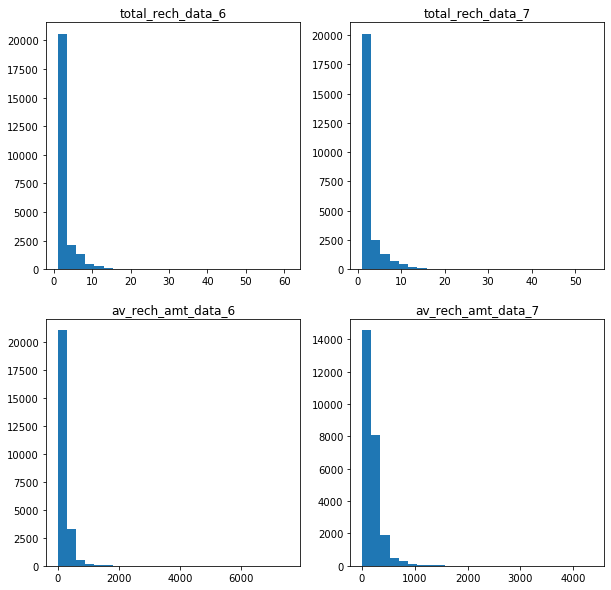

In [11]:
# Let us look at the distribution to find out the value to fill
# total_rech_data_6
plt.figure(1)
fig, ax = plt.subplots(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("total_rech_data_6")
plt.hist(telecom.total_rech_data_6.dropna(),bins=25)

# total_rech_data_7
plt.subplot(2,2,2)
plt.title("total_rech_data_7")
plt.hist(telecom.total_rech_data_7.dropna(),bins=25)

# av_rech_amt_data_6
plt.subplot(2,2,3)
plt.title("av_rech_amt_data_6")
plt.hist(telecom.av_rech_amt_data_6.dropna(),bins=25)

# total_rech_data_7
plt.subplot(2,2,4)
plt.title("av_rech_amt_data_7")
plt.hist(telecom.av_rech_amt_data_7.dropna(),bins=25)

### Insights from the distribution graphs
- Variables are numeric.
- The minimum value is 1, and not zero,


In [12]:
# missing -- indicating that no recharge was done in this month. 
# Thus, missing values can be imputed with 0.

telecom.total_rech_data_6.fillna(value=0, inplace=True)
telecom.total_rech_data_7.fillna(value=0, inplace=True)
telecom.total_rech_data_8.fillna(value=0, inplace=True)
telecom.total_rech_data_9.fillna(value=0, inplace=True)

telecom.av_rech_amt_data_6.fillna(value=0, inplace=True)
telecom.av_rech_amt_data_7.fillna(value=0, inplace=True)
telecom.av_rech_amt_data_8.fillna(value=0, inplace=True)
telecom.av_rech_amt_data_9.fillna(value=0, inplace=True)

In [13]:
#Column analysis % of missing values
print(round(100*(telecom.isnull().sum()/len(telecom.index)), 2)); print_ln()

# Columns with more than 70% missing values
colmns_missing_data = round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
print(colmns_missing_data[colmns_missing_data >= 70])

mobile_number    0.00
circle_id        0.00
loc_og_t2o_mou   1.02
std_og_t2o_mou   1.02
loc_ic_t2o_mou   1.02
                 ... 
fb6_1.0          0.00
fb7_0.0          0.00
fb7_1.0          0.00
fb8_0.0          0.00
fb8_1.0          0.00
Length: 232, dtype: float64
-------------------------------------------------------------------------------- 

date_of_last_rech_data_6   74.85
date_of_last_rech_data_7   74.43
date_of_last_rech_data_8   73.66
date_of_last_rech_data_9   74.08
max_rech_data_6            74.85
max_rech_data_7            74.43
max_rech_data_8            73.66
max_rech_data_9            74.08
count_rech_2g_6            74.85
count_rech_2g_7            74.43
count_rech_2g_8            73.66
count_rech_2g_9            74.08
count_rech_3g_6            74.85
count_rech_3g_7            74.43
count_rech_3g_8            73.66
count_rech_3g_9            74.08
arpu_3g_6                  74.85
arpu_3g_7                  74.43
arpu_3g_8                  73.66
arpu_3g_9           

In [14]:
drop_missing_values_columns = colmns_missing_data[colmns_missing_data > 70].index
telecom.drop(drop_missing_values_columns, axis=1, inplace=True)

print('Number of columns droped here  = ', len(drop_missing_values_columns))
print('Dataframe Shape: ', telecom.shape)

Number of columns droped here  =  24
Dataframe Shape:  (99999, 208)


##### Filter High-Value Customers

In [15]:
# New DERIVED Columns for Total Data Recharge Amount

telecom["total_rech_data_amt_6"] = telecom["total_rech_data_6"]*telecom['av_rech_amt_data_6']
telecom["total_rech_data_amt_7"] = telecom["total_rech_data_7"]*telecom['av_rech_amt_data_7']
telecom["total_rech_data_amt_8"] = telecom["total_rech_data_8"]*telecom['av_rech_amt_data_8']
telecom["total_rech_data_amt_9"] = telecom["total_rech_data_9"]*telecom['av_rech_amt_data_9']

# We can drop total_rech_data_* and av_rech_amt_data_*
drop_data_columns = ["total_rech_data_6", "total_rech_data_7", "total_rech_data_8", "total_rech_data_9", 
                'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']
telecom.drop(drop_data_columns, axis=1, inplace=True)

In [16]:
# Filter high-value customers
avg_rech_amt_6_7 = (telecom["total_rech_amt_6"] + telecom["total_rech_data_amt_6"] + 
                      telecom["total_rech_amt_7"] + telecom["total_rech_data_amt_7"]) / 2.0
amont_70_pc = np.percentile(avg_rech_amt_6_7, 70.0)
print('70 percentile of first two months avg recharge amount: ', amont_70_pc)

telecom = telecom[avg_rech_amt_6_7 >= amont_70_pc]
print('Dataframe Shape: ', telecom.shape)

70 percentile of first two months avg recharge amount:  478.0
Dataframe Shape:  (30001, 204)


#### Identify Curn & Tag Churners

In [17]:
# Identify Churn
X = telecom["total_ic_mou_9"] + telecom["total_og_mou_9"] + telecom["vol_2g_mb_9"] + telecom["vol_3g_mb_9"]
telecom["churn"] = np.where(X, 0, 1)
#telecom["churn"].head(10)

# Columns to be dropped: all columns ending with "_9"
drop_fourth_month_columns = [hdr for hdr in list(telecom) if hdr.endswith("_9")]
drop_fourth_month_columns += ["sep_vbc_3g"]
telecom.drop(drop_fourth_month_columns, axis=1, inplace=True)

print('Number of columns droped here  = ', len(drop_fourth_month_columns))
print('Dataframe Shape: ', telecom.shape); print_ln();

Number of columns droped here  =  48
Dataframe Shape:  (30001, 157)
-------------------------------------------------------------------------------- 



#### Identify columns that have no varience & Drop

In [18]:
#Identify columns that have no varience
telecom_unique_count = telecom.nunique().sort_values(ascending=False)


# Identify bad colums that has no infromation (all entries are NA or same)
# Find columns with all NULL entries and add to drop_columns list
telecom_unique_count_is_zero = telecom_unique_count[telecom_unique_count == 0]
print("Dataframe Unique Value Count is ZERO (all null values): \n", telecom_unique_count_is_zero); print_ln();
drop_no_varience_columns = list(telecom_unique_count_is_zero.index)

# Find columns with all same entries and add to drop_columns list
telecom_unique_count_is_one = telecom_unique_count[telecom_unique_count == 1]
print("Dataframe Unique Value Count is ONE (all same values): \n", telecom_unique_count_is_one); print_ln();
drop_no_varience_columns += list(telecom_unique_count_is_one.index)

telecom.drop(drop_no_varience_columns, axis=1, inplace=True)

print('Dataframe Shape: ', telecom.shape); print_ln();
print('Number of columns dropped here  = ', len(drop_no_varience_columns))
print('Dataframe Shape: ', telecom.shape); print_ln();

Dataframe Unique Value Count is ZERO (all null values): 
 Series([], dtype: int64)
-------------------------------------------------------------------------------- 

Dataframe Unique Value Count is ONE (all same values): 
 last_date_of_month_7    1
circle_id               1
loc_og_t2o_mou          1
std_og_t2o_mou          1
loc_ic_t2o_mou          1
last_date_of_month_6    1
std_ic_t2o_mou_6        1
last_date_of_month_8    1
std_ic_t2o_mou_7        1
std_og_t2c_mou_6        1
std_og_t2c_mou_7        1
std_og_t2c_mou_8        1
std_ic_t2o_mou_8        1
dtype: int64
-------------------------------------------------------------------------------- 

Dataframe Shape:  (30001, 144)
-------------------------------------------------------------------------------- 

Number of columns dropped here  =  13
Dataframe Shape:  (30001, 144)
-------------------------------------------------------------------------------- 



#### ROW-WISE: MISSING VALUES

In [19]:
# sum it up to check how many rows have all missing values
print("Rows with all NULL values =",  telecom.isnull().all(axis=1).sum())

# sum of misisng values in each row
rows_missing_data = telecom.isnull().sum(axis=1)
rows_missing_data[rows_missing_data > 0]

Rows with all NULL values = 0


0        54
77       27
91        1
111      27
188      28
         ..
99672     1
99700    27
99790    55
99827    27
99851    56
Length: 1838, dtype: int64

In [20]:
#small percentage of rows has more than or equal to 27 missing values
drop_rows = telecom.isnull().sum(axis=1) >= 27
print("Number of rows with >= 27 missing values = {}".format(drop_rows.sum()))
print("     % of rows with >= 27 missing values = {} %".format(drop_rows.sum()/telecom.shape[0]*100))

# drop rows with missing values greater >= 27
telecom = telecom[telecom.isnull().sum(axis=1) < 27]
print('Dataframe Shape after dropping rows: ', telecom.shape); print_ln();

Number of rows with >= 27 missing values = 1497
     % of rows with >= 27 missing values = 4.989833672210926 %
Dataframe Shape after dropping rows:  (28504, 144)
-------------------------------------------------------------------------------- 



In [21]:
rows_missing_data = telecom.isnull().sum(axis=1)
print(rows_missing_data[rows_missing_data > 0])

91       1
191      1
588      1
603      2
679      1
        ..
98971    1
99224    2
99313    1
99515    1
99672    1
Length: 341, dtype: int64


In [22]:
# look at the COLUMN summary again
df = round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
df[df > 0]

date_of_last_rech_6   0.12
date_of_last_rech_7   0.18
date_of_last_rech_8   0.97
dtype: float64

 The remaining missing values are in date columns, before imputing convert them into appropreate values for analysis.

#### Fix Dates & convert to meaningful numbers

In [23]:
# covert date columns to python datetime format
date_vars = ["date_of_last_rech_6",  "date_of_last_rech_7", "date_of_last_rech_8"]
telecom[date_vars].head()

date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8
7            6/27/2014           7/25/2014           8/26/2014
8            6/25/2014           7/31/2014           8/30/2014
21           6/30/2014           7/31/2014           8/31/2014
23           6/18/2014            7/7/2014           8/24/2014
33           6/30/2014           7/30/2014           8/26/2014

In [24]:
# convert to datetime
for col in date_vars:
    telecom[col] = pd.to_datetime(telecom[col])

print(telecom[date_vars].info())
telecom[date_vars].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28504 entries, 7 to 99997
Data columns (total 3 columns):
date_of_last_rech_6    28471 non-null datetime64[ns]
date_of_last_rech_7    28452 non-null datetime64[ns]
date_of_last_rech_8    28228 non-null datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 890.8 KB
None


date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8
7           2014-06-27          2014-07-25          2014-08-26
8           2014-06-25          2014-07-31          2014-08-30
21          2014-06-30          2014-07-31          2014-08-31
23          2014-06-18          2014-07-07          2014-08-24
33          2014-06-30          2014-07-30          2014-08-26

In [25]:
# Create new days columns, instead of date
import datetime
last_date_of_month_6 = datetime.datetime.strptime("30-06-2014", "%d-%m-%Y")
last_date_of_month_7 = datetime.datetime.strptime("31-07-2014", "%d-%m-%Y")
last_date_of_month_8 = datetime.datetime.strptime("31-08-2014", "%d-%m-%Y")

telecom["rech_days_left_6"]      = (last_date_of_month_6 - telecom.date_of_last_rech_6).astype('timedelta64[D]')
telecom["rech_days_left_7"]      = (last_date_of_month_7 - telecom.date_of_last_rech_7).astype('timedelta64[D]')
telecom["rech_days_left_8"]      = (last_date_of_month_8 - telecom.date_of_last_rech_8).astype('timedelta64[D]')

day_columns = ["rech_days_left_6", "rech_days_left_7", "rech_days_left_8"]
print(telecom[day_columns].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28504 entries, 7 to 99997
Data columns (total 3 columns):
rech_days_left_6    28471 non-null float64
rech_days_left_7    28452 non-null float64
rech_days_left_8    28228 non-null float64
dtypes: float64(3)
memory usage: 890.8 KB
None


In [26]:
# Drop all old date columns: add dates columns to drop_column list
telecom.drop(date_vars, axis=1, inplace=True)
telecom1 = telecom.copy()

print('Number of columns droped here  = ', len(date_vars))
print('Dataframe Shape: ', telecom.shape)

Number of columns droped here  =  3
Dataframe Shape:  (28504, 144)


In [27]:
# look at the COLUMN summary again
df = round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
df[df > 0]

rech_days_left_6   0.12
rech_days_left_7   0.18
rech_days_left_8   0.97
dtype: float64

In [28]:
telecom[['rech_days_left_6', 'rech_days_left_7', 'rech_days_left_8']].describe()

rech_days_left_6  rech_days_left_7  rech_days_left_8
count          28471.00          28452.00          28228.00
mean               3.39              3.49              4.15
std                4.49              4.29              5.10
min                0.00              0.00              0.00
25%                0.00              0.00              1.00
50%                2.00              2.00              3.00
75%                4.00              5.00              6.00
max               29.00             30.00             30.00

In [29]:
# Mean & Median are different: imputing with median value for recharge days left 
telecom.loc[np.isnan(telecom['rech_days_left_6']), ['rech_days_left_6']] = telecom['rech_days_left_6'].median()
telecom.loc[np.isnan(telecom['rech_days_left_7']), ['rech_days_left_7']] = telecom['rech_days_left_7'].median()
telecom.loc[np.isnan(telecom['rech_days_left_8']), ['rech_days_left_8']] = telecom['rech_days_left_8'].median()


print("\nTotal Number of missing values in the data frame = {}".format(telecom.isnull().sum().sum()))
print('Dataframe Shape: ', telecom.shape); print_ln();


Total Number of missing values in the data frame = 0
Dataframe Shape:  (28504, 144)
-------------------------------------------------------------------------------- 



#### Outlier Assessment

Use data distribution to find outliers

In [30]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
telecom.describe(percentiles=[.25,.5,.75,.90,.95,.99])

mobile_number   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  \
count       28504.00 28504.00 28504.00 28504.00     28504.00     28504.00   
mean   7001213864.75   560.38   570.63   526.06       265.25       275.93   
std        687776.04   448.96   480.08   500.75       458.72       482.67   
min    7000000074.00 -2258.71 -2014.05  -945.81         0.00         0.00   
25%    7000622950.00   317.36   322.60   254.76        20.14        19.53   
50%    7001217677.00   485.17   488.90   442.79        89.98        89.91   
75%    7001806580.25   698.91   705.00   672.45       298.76       304.89   
90%    7002165664.10   987.58  1001.34   991.09       760.84       801.71   
95%    7002285365.20  1232.63  1268.47  1267.39      1135.71      1206.17   
99%    7002385436.73  1955.15  1999.46  1989.92      2146.08      2220.47   
max    7002410905.00 27731.09 35145.83 33543.62      7376.71      8157.78   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  fb7_1.0  \
count     28504.00      28504.00      28504.00      28504.00  ... 28504.00   
mean        244.73        379.89        389.85        350.23  ...     0.52   
std         464.02        479.25        502.60        485.65  ...     0.50   
min           0.00          0.00          0.00          0.00  ...     0.00   
25%          14.84         80.73         80.35         60.49  ...     0.00   
50%          74.09        231.55        231.82        199.88  ...     1.00   
75%         257.41        494.37        506.47        457.43  ...     1.00   
90%         688.28        898.93        931.20        844.92  ...     1.00   
95%        1101.55       1256.09       1292.28       1187.34  ...     1.00   
99%        2175.25       2301.03       2434.54       2219.38  ...     1.00   
max       10752.56       8362.36       9667.13      14007.34  ...     1.00   

       fb8_0.0  fb8_1.0  total_rech_data_amt_6  total_rech_data_amt_7  \
count 28504.00 28504.00               28504.00               28504.00   
mean      0.06     0.48                 444.79                 527.56   
std       0.23     0.50                1417.12                1481.60   
min       0.00     0.00                   0.00                   0.00   
25%       0.00     0.00                   0.00                   0.00   
50%       0.00     0.00                  92.00                 100.00   
75%       0.00     1.00                 392.00                 575.00   
90%       0.00     1.00                1051.40                1374.00   
95%       1.00     1.00                2025.00                2424.00   
99%       1.00     1.00                5129.73                6219.16   
max       1.00     1.00              105644.00               55080.00   

       total_rech_data_amt_8    churn  rech_days_left_6  rech_days_left_7  \
count               28504.00 28504.00          28504.00          28504.00   
mean                  469.51     0.06              3.39              3.48   
std                  1644.91     0.23              4.49              4.29   
min                     0.00     0.00              0.00              0.00   
25%                     0.00     0.00              0.00              0.00   
50%                    25.00     0.00              2.00              2.00   
75%                   342.00     0.00              4.00              5.00   
90%                  1118.80     0.00             10.00              9.00   
95%                  2268.00     1.00             14.00             13.00   
99%                  5749.82     1.00             19.00             18.00   
max                 89106.50     1.00             29.00             30.00   

       rech_days_left_8  
count          28504.00  
mean               4.14  
std                5.08  
min                0.00  
25%                1.00  
50%                3.00  
75%                6.00  
90%               10.00  
95%               15.00  
99%               25.00  
max               30.00  

[11 rows x 144 columns]

- Most of the outliers are on the revenue data and the model being built is on usage of voice and data.Hence there is no need to treat these outliers

In [31]:
print('Original Dataframe Shape: ', telecom_orig.shape); print_ln();
print("Original Dataframe Info: \n"); telecom_orig.info(); print_ln();
print("Original Dataframe Nulls:", telecom_orig.isnull().sum().sum()); print_ln();

print('Cleaned Dataframe Shape: ', telecom.shape); print_ln();
print("Cleaned Dataframe Info: \n"); telecom.info(); print_ln();
print("Cleaned Dataframe Nulls:", telecom.isnull().sum().sum()); print_ln();

Original Dataframe Shape:  (99999, 226)
-------------------------------------------------------------------------------- 

Original Dataframe Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB
-------------------------------------------------------------------------------- 

Original Dataframe Nulls: 3594931
-------------------------------------------------------------------------------- 

Cleaned Dataframe Shape:  (28504, 144)
-------------------------------------------------------------------------------- 

Cleaned Dataframe Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28504 entries, 7 to 99997
Columns: 144 entries, mobile_number to rech_days_left_8
dtypes: float64(105), int64(27), uint8(12)
memory usage: 29.2 MB
-------------------------------------------------------------------------------- 

Cleaned Dataframe Nulls: 0
-

#### Save the cleaned data in new file

In [32]:
# write treated telecom file
telecom.to_csv("../data/processed/telecom_churn_data_clean.csv", sep=',', index=False)

#### Dependent Variable: check data imbalance

In [33]:
#checking whether data is imbalanced or not
churn  = telecom["churn"].value_counts()
churn_rate = churn[1]/(churn[1] + churn[0])

print("Total Churn Count     = {}".format(churn[1]))
print("Total Not-Churn Count = {}".format(churn[0]))
print("Churn Rate            = {:.2f}%".format(churn_rate*100))
print_ln()

Total Churn Count     = 1596
Total Not-Churn Count = 26908
Churn Rate            = 5.60%
-------------------------------------------------------------------------------- 



Data is highly imbalanced, we need to balance it before we can create the model

### Data Analysis

#### 1) Univariate Analysis
- now use histogram or probability density function for univiraite analysis
- one variable analysis
- this is important to know feature importance in classification

##### 1.1) Univariate Analysis on 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8

In [34]:
#Univariate Analysis on 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8
df_not_churn = telecom[telecom["churn"] == 0]
df_churn     = telecom[telecom["churn"] == 1]

In [35]:
#claculation of mean for churn or non churn
print("Mean:")
print(np.mean(df_not_churn["total_rech_num_6"]))
print(np.mean(df_churn["total_rech_num_6"]))
print("median:")
print(np.median(df_not_churn["total_rech_num_6"]))
print(np.median(df_churn["total_rech_num_6"]))

print("Quantiles:")
print(np.percentile(df_not_churn["total_rech_num_6"],np.arange(0,100,25)))
print(np.percentile(df_churn["total_rech_num_6"],np.arange(0,100,25)))

Mean:
11.826036866359447
14.31704260651629
median:
9.0
12.0
Quantiles:
[ 0.  6.  9. 14.]
[ 0.  8. 12. 18.]


/Users/eklavya/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


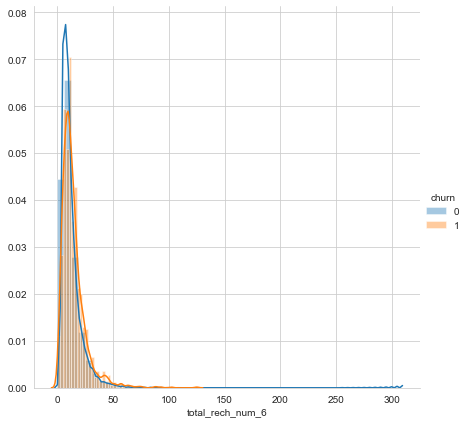

In [36]:
#feature importance of total_rech_num_6
sns.set_style('whitegrid')
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"total_rech_num_6").add_legend()

#its difficult to know about the churning rate based on total_rech_num_6 feature as overlaped data.

In [37]:
print("Mean:")
print(np.mean(df_not_churn["total_rech_num_7"]))
print(np.mean(df_churn["total_rech_num_7"]))
print("median:")
print(np.median(df_not_churn["total_rech_num_7"]))
print(np.median(df_churn["total_rech_num_7"]))

print("Quantiles:")
print(np.percentile(df_not_churn["total_rech_num_7"],np.arange(0,100,25)))
print(np.percentile(df_churn["total_rech_num_7"],np.arange(0,100,25)))

Mean:
11.875464545859968
13.43170426065163
median:
9.0
10.0
Quantiles:
[ 0.  6.  9. 15.]
[ 0.  7. 10. 17.]


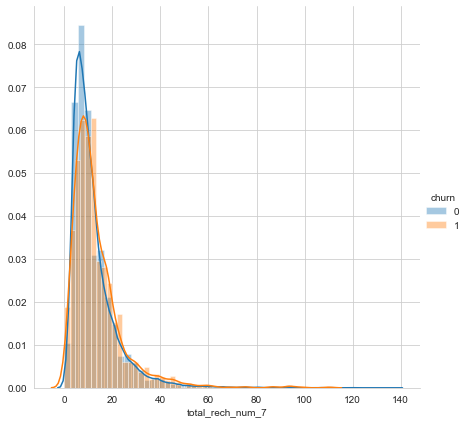

In [38]:

#feature importance of total_rech_data_7

sns.set_style('whitegrid')
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"total_rech_num_7").add_legend()

#its difficult to know about the churning rate based on total_rech_data_7 feature as overlaped data.

In [39]:
print("Mean:")
print(np.mean(df_not_churn["total_rech_num_8"]))
print(np.mean(df_churn["total_rech_num_8"]))
print("median:")
print(np.median(df_not_churn["total_rech_num_8"]))
print(np.median(df_churn["total_rech_num_8"]))

print("Quantiles:")
print(np.percentile(df_not_churn["total_rech_num_8"],np.arange(0,100,25)))
print(np.percentile(df_churn["total_rech_num_8"],np.arange(0,100,25)))

Mean:
10.523561766017542
7.021303258145363
median:
8.0
5.0
Quantiles:
[ 0.  5.  8. 13.]
[0. 3. 5. 9.]


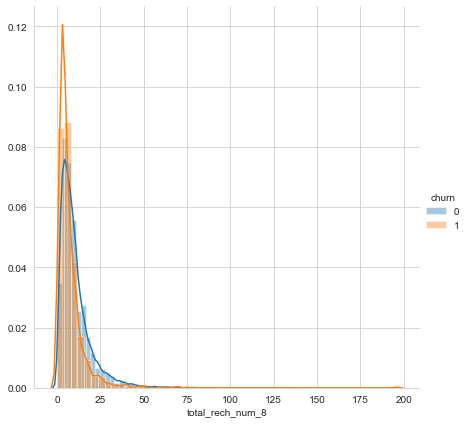

In [40]:
#feature importance of total_rech_amt_8
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"total_rech_num_8").add_legend()

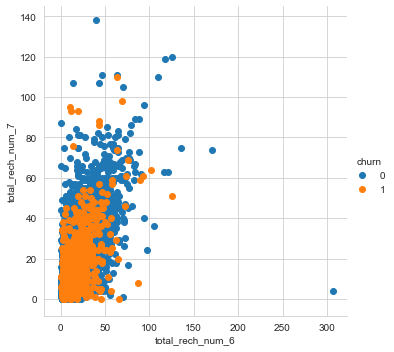

In [41]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"total_rech_num_6","total_rech_num_7").add_legend()

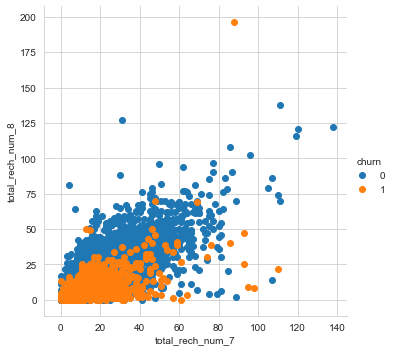

In [42]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"total_rech_num_7","total_rech_num_8").add_legend()

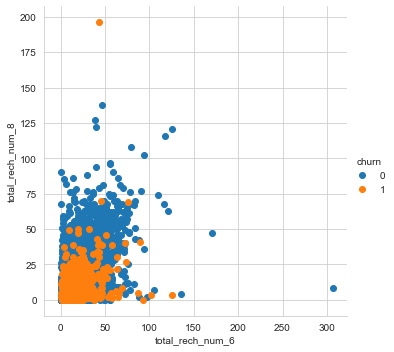

In [43]:

sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"total_rech_num_6","total_rech_num_8").add_legend()

##### 1.2) Univariate Analysis on 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8'

In [44]:
print("Mean:")
print(np.mean(df_not_churn["total_rech_amt_6"]))
print(np.mean(df_churn["total_rech_amt_6"]))
print("median:")
print(np.median(df_not_churn["total_rech_amt_6"]))
print(np.median(df_churn["total_rech_amt_6"]))

print("Quantiles:")
print(np.percentile(df_not_churn["total_rech_amt_6"],np.arange(0,100,25)))
print(np.percentile(df_churn["total_rech_amt_6"],np.arange(0,100,25)))

Mean:
656.1418537237996
786.3007518796992
median:
564.0
669.0
Quantiles:
[  0. 366. 564. 820.]
[  0. 450. 669. 984.]


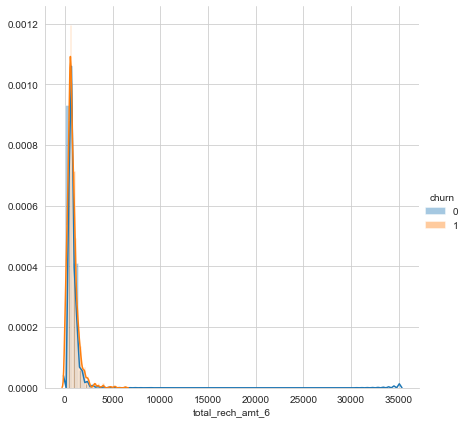

In [45]:
#feature importance of total_rech_num_6

sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"total_rech_amt_6").add_legend()

In [46]:
print("Mean:")
print(np.mean(df_not_churn["total_rech_amt_7"]))
print(np.mean(df_churn["total_rech_amt_7"]))
print("median:")
print(np.median(df_not_churn["total_rech_amt_7"]))
print(np.median(df_churn["total_rech_amt_7"]))

print("Quantiles:")
print(np.percentile(df_not_churn["total_rech_amt_7"],np.arange(0,100,25)))
print(np.percentile(df_churn["total_rech_amt_7"],np.arange(0,100,25)))

Mean:
668.5358257767207
733.1115288220551
median:
570.0
616.0
Quantiles:
[  0. 366. 570. 833.]
[  0.   382.75 616.   939.25]


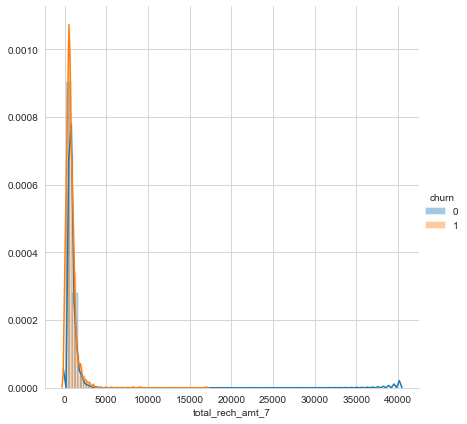

In [47]:
#feature importance of total_rech_num_6

sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"total_rech_amt_7").add_legend()

In [48]:
print("Mean:")
print(np.mean(df_not_churn["total_rech_amt_8"]))
print(np.mean(df_churn["total_rech_amt_8"]))
print("median:")
print(np.median(df_not_churn["total_rech_amt_8"]))
print(np.median(df_churn["total_rech_amt_8"]))

print("Quantiles:")
print(np.percentile(df_not_churn["total_rech_amt_8"],np.arange(0,100,25)))
print(np.percentile(df_churn["total_rech_amt_8"],np.arange(0,100,25)))

Mean:
619.713691095585
352.98809523809524
median:
518.0
190.0
Quantiles:
[  0. 288. 518. 800.]
[  0.    16.5  190.   506.25]


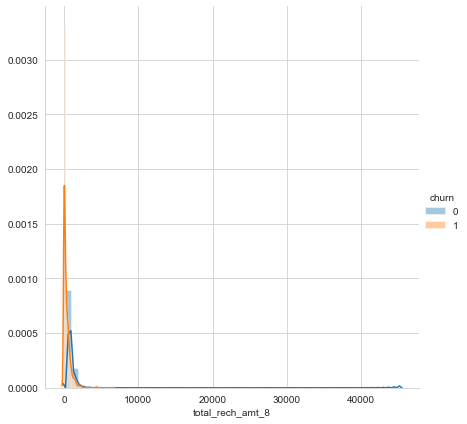

In [49]:
#feature importance of total_rech_num_6

sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"total_rech_amt_8").add_legend()

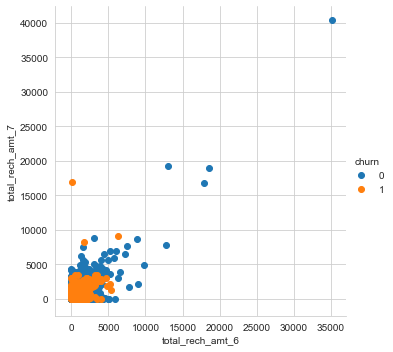

In [50]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"total_rech_amt_6","total_rech_amt_7").add_legend()

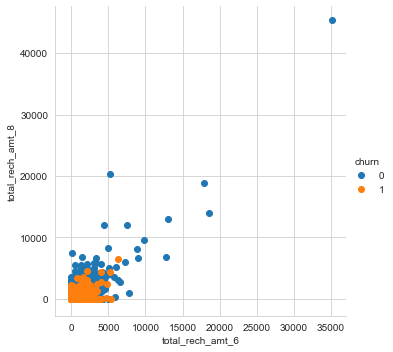

In [51]:

sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"total_rech_amt_6","total_rech_amt_8").add_legend()

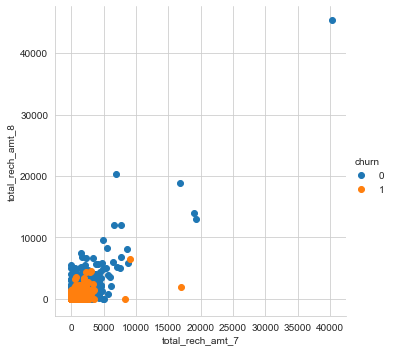

In [52]:

sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"total_rech_amt_7","total_rech_amt_8").add_legend()

##### 1.3) Univariate Analysis on max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',

In [53]:
print("Mean:")
print(np.mean(df_not_churn["max_rech_amt_6"]))
print(np.mean(df_churn["max_rech_amt_6"]))
print("median:")
print(np.median(df_not_churn["max_rech_amt_6"]))
print(np.median(df_churn["max_rech_amt_6"]))

print("Quantiles:")
print(np.percentile(df_not_churn["max_rech_amt_6"],np.arange(0,100,25)))
print(np.percentile(df_churn["max_rech_amt_6"],np.arange(0,100,25)))

Mean:
168.3110227441653
158.79761904761904
median:
120.0
110.0
Quantiles:
[  0. 110. 120. 200.]
[  0. 100. 110. 154.]


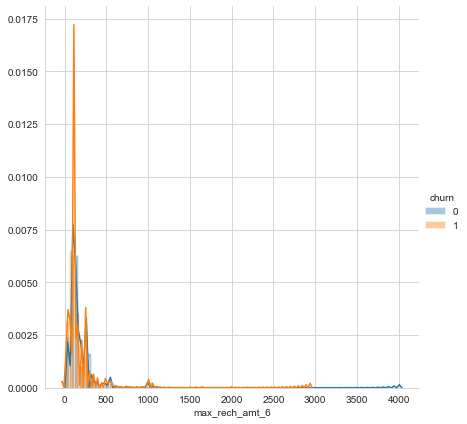

In [54]:
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"max_rech_amt_6").add_legend()

In [55]:
print("Mean:")
print(np.mean(df_not_churn["max_rech_amt_7"]))
print(np.mean(df_churn["max_rech_amt_7"]))
print("median:")
print(np.median(df_not_churn["max_rech_amt_7"]))
print(np.median(df_churn["max_rech_amt_7"]))

print("Quantiles:")
print(np.percentile(df_not_churn["max_rech_amt_7"],np.arange(0,100,25)))
print(np.percentile(df_churn["max_rech_amt_7"],np.arange(0,100,25)))

Mean:
171.94440315147912
159.51629072681703
median:
130.0
110.0
Quantiles:
[  0. 110. 130. 200.]
[  0.  98. 110. 154.]


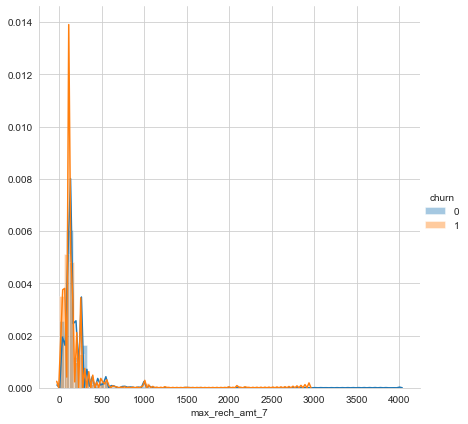

In [56]:
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"max_rech_amt_7").add_legend()

In [57]:
print("Mean:")
print(np.mean(df_not_churn["max_rech_amt_8"]))
print(np.mean(df_churn["max_rech_amt_8"]))
print("median:")
print(np.median(df_not_churn["max_rech_amt_8"]))
print(np.median(df_churn["max_rech_amt_8"]))

print("Quantiles:")
print(np.percentile(df_not_churn["max_rech_amt_8"],np.arange(0,100,25)))
print(np.percentile(df_churn["max_rech_amt_8"],np.arange(0,100,25)))

Mean:
166.4161959268619
111.0983709273183
median:
144.0
56.0
Quantiles:
[  0.  70. 144. 198.]
[  0.  10.  56. 130.]


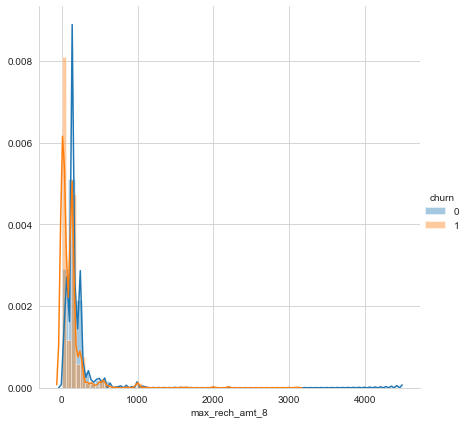

In [58]:
sns.FacetGrid(telecom,hue='churn',size=6).map(sns.distplot,"max_rech_amt_8").add_legend()

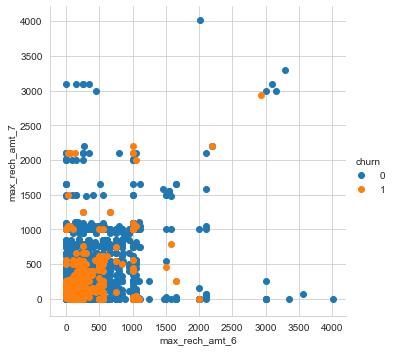

In [59]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"max_rech_amt_6","max_rech_amt_7").add_legend()

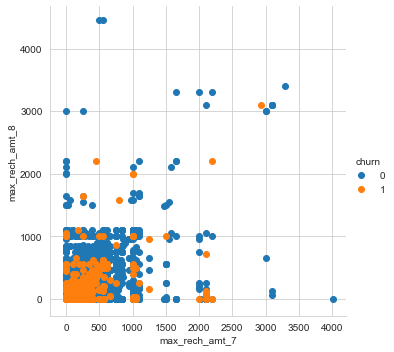

In [60]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"max_rech_amt_7","max_rech_amt_8").add_legend()

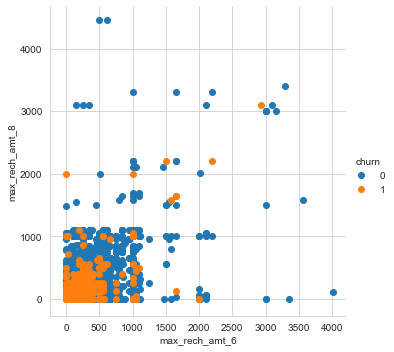

In [61]:
sns.FacetGrid(telecom,hue='churn',size=5).map(plt.scatter,"max_rech_amt_6","max_rech_amt_8").add_legend()

#### 2) Bivariate Analysis

In [62]:
telecom2 = telecom.drop(['mobile_number', 'churn'], axis=1)

In [63]:
# Create correlation matrix
corr_matrix = telecom2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.80
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.80)]

print("HIGHLY CORRELATED FEATURES IN DATA SET:{}\n\n{}".format(len(high_corr_features), high_corr_features))

HIGHLY CORRELATED FEATURES IN DATA SET:36

['onnet_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_7', 'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'isd_og_mou_7', 'isd_og_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'fb6_1.0', 'fb7_1.0', 'fb8_1.0']


- 36 highly correlated features (> 80%) found in the data set.
- NOTE: We are not dropping these columns manually rather using feature reduction methods to do the job. We worked with RFE, LASSO and PCA.

#### OBSERVATIONS

- Data is higly imbalanced only 5.6% data is churn & remaining is non_churn
- From univariate analysis some relationship is emerging to the churn, but no clear relationship found.
- There are many highly correlated features, found 36 features with more then 0.8 correlation.

#### Next Steps: 

- Need to balance the data, apply suitable data-balancing method
- Features are highly correlated, use feture reduction methods before modelling.

#### Model Building and Evaluation

Let's first build a decision tree with default hyperparameters. Then we'll use cross-validation to tune them.

In [64]:
# Importing train-test-split 
from sklearn.model_selection import train_test_split

In [65]:
# Putting feature variable to X
X = telecom.drop('churn',axis=1)

# Putting response variable to y
y = telecom['churn']

In [66]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state = 99)
X_train.head()

mobile_number  arpu_6  arpu_7  arpu_8  onnet_mou_6  onnet_mou_7  \
36531     7002179476  532.55  435.05  421.63       826.34       527.81   
89172     7000622689  403.89  506.86  447.43        26.31        64.63   
89748     7001761227  785.48  731.96  726.15      1325.58      1349.84   
64670     7000837248  658.03  521.59   53.10        71.78        82.86   
4001      7000826223  471.57  446.59  420.69        59.81        97.78   

       onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  fb7_0.0  \
36531       295.84         72.78        267.46         53.04  ...        0   
89172        14.08        326.91        341.98        319.63  ...        0   
89748      1160.68         56.19         31.54        130.21  ...        0   
64670        11.91       1521.94       1042.01         39.48  ...        0   
4001         55.51        316.66        394.28        329.91  ...        0   

       fb7_1.0  fb8_0.0  fb8_1.0  total_rech_data_amt_6  \
36531        0        0        0                   0.00   
89172        0        0        0                   0.00   
89748        0        0        0                   0.00   
64670        0        0        0                   0.00   
4001         0        0        0                   0.00   

       total_rech_data_amt_7  total_rech_data_amt_8  rech_days_left_6  \
36531                   0.00                   0.00              0.00   
89172                   0.00                   0.00              6.00   
89748                   0.00                   0.00              0.00   
64670                   0.00                   0.00              1.00   
4001                    0.00                   0.00              5.00   

       rech_days_left_7  rech_days_left_8  
36531              0.00              0.00  
89172              3.00              0.00  
89748              0.00              0.00  
64670              0.00              9.00  
4001               0.00              3.00  

[5 rows x 143 columns]

In [67]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [68]:
# Let's check the evaluation metrics of our default model

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix

# Making predictions
y_pred_default = dt_default.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      8055
           1       0.53      0.35      0.42       497

    accuracy                           0.94      8552
   macro avg       0.74      0.66      0.69      8552
weighted avg       0.94      0.94      0.94      8552



In [69]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred_default))


[[7900  155]
 [ 325  172]]


#### Plotting the Decision Tree
We need the graphviz library to plot a tree.

In [70]:
# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

# Putting features
features = list(telecom.columns[1:])
features

/Users/eklavya/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t

Python requires library pydot and an external software graphviz to visualize the decision tree.

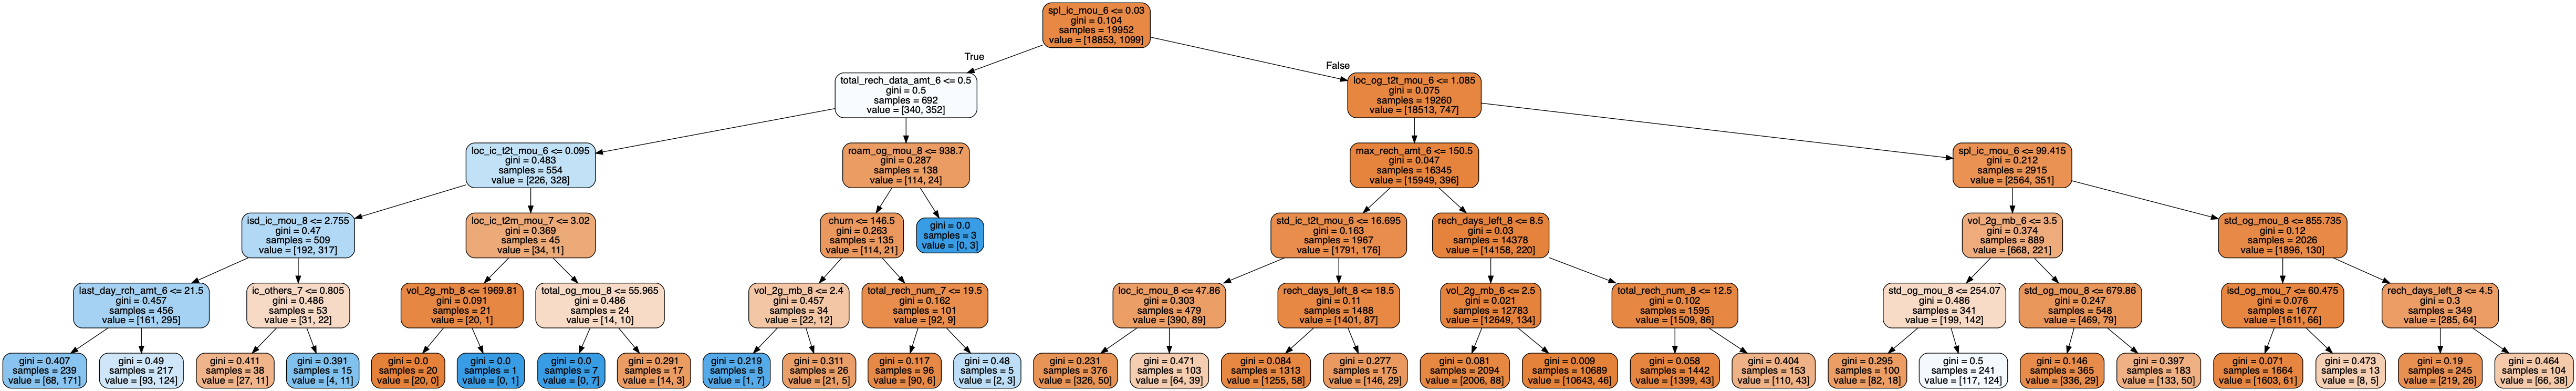

In [71]:
# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(dt_default, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Hyperparameter Tuning
The default tree is quite complex, and we need to simplify it by tuning the hyperparameters.

First, let's understand the parameters in a decision tree.

- criterion (Gini/IG or entropy): It defines the function to measure the quality of a split. Sklearn supports “gini” criteria for Gini Index & “entropy” for Information Gain. By default, it takes the value “gini”.
- splitter: It defines the strategy to choose the split at each node. Supports “best” value to choose the best split & “random” to choose the best random split. By default, it takes “best” value.
- max_features: It defines the no. of features to consider when looking for the best split. We can input integer, float, string & None value.
    - If an integer is inputted then it considers that value as max features at each split.
    - If float value is taken then it shows the percentage of features at each split.
    - If “auto” or “sqrt” is taken then max_features=sqrt(n_features).
    - If “log2” is taken then max_features= log2(n_features).
    - If None, then max_features=n_features. By default, it takes “None” value.
- max_depth: The max_depth parameter denotes maximum depth of the tree. It can take any integer value or None. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. By default, it takes “None” value.
- min_samples_split: This tells above the minimum no. of samples reqd. to split an internal node. If an integer value is taken then consider min_samples_split as the minimum no. If float, then it shows percentage. By default, it takes “2” value.
- min_samples_leaf: The minimum number of samples required to be at a leaf node. If an integer value is taken then consider - -min_samples_leaf as the minimum no. If float, then it shows percentage. By default, it takes “1” value.
- max_leaf_nodes: It defines the maximum number of possible leaf nodes. If None then it takes an unlimited number of leaf nodes. By default, it takes “None” value.
- min_impurity_split: It defines the threshold for early stopping tree growth. A node will split if its impurity is above the threshold otherwise it is a leaf.

#### Tuning max_depth
Let's first try to find the optimum values for max_depth and understand how the value of max_depth affects the decision tree.

Here, we are creating a dataframe with max_depth in range 1 to 80 and checking the accuracy score corresponding to each max_depth.

To reiterate, a grid search scheme consists of:

- an estimator (classifier such as SVC() or decision tree)
- a parameter space
- a method for searching or sampling candidates (optional) 
- a cross-validation scheme, and
- a score function (accuracy, roc_auc etc.)

In [72]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, cv=n_folds,return_train_score=True,scoring="accuracy")

tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': range(1, 40)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='

In [73]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0           0.16          0.05             0.01            0.00   
1           0.25          0.04             0.01            0.00   
2           0.33          0.01             0.01            0.00   
3           0.45          0.03             0.01            0.00   
4           0.61          0.09             0.01            0.00   

  param_max_depth            params  split0_test_score  split1_test_score  \
0               1  {'max_depth': 1}               0.94               0.95   
1               2  {'max_depth': 2}               0.95               0.95   
2               3  {'max_depth': 3}               0.95               0.95   
3               4  {'max_depth': 4}               0.95               0.95   
4               5  {'max_depth': 5}               0.95               0.94   

   split2_test_score  split3_test_score  ...  mean_test_score  std_test_score  \
0               0.95               0.94  ...             0.94            0.00   
1               0.95               0.95  ...             0.95            0.00   
2               0.95               0.95  ...             0.95            0.00   
3               0.95               0.95  ...             0.95            0.00   
4               0.94               0.95  ...             0.95            0.00   

   rank_test_score  split0_train_score  split1_train_score  \
0                5                0.94                0.95   
1                2                0.95                0.95   
2                1                0.95                0.95   
3                3                0.95                0.95   
4                4                0.95                0.95   

   split2_train_score  split3_train_score  split4_train_score  \
0                0.95                0.95                0.95   
1                0.95                0.95                0.95   
2                0.95                0.95                0.95   
3                0.95                0.95                0.95   
4                0.95                0.95                0.95   

   mean_train_score  std_train_score  
0              0.95             0.00  
1              0.95             0.00  
2              0.95             0.00  
3              0.95             0.00  
4              0.95             0.00  

[5 rows x 21 columns]

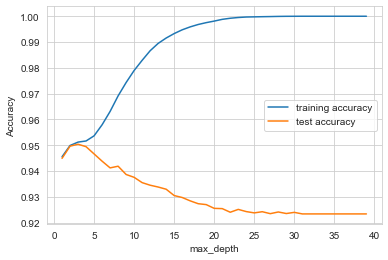

In [74]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


We can see that as we increase the value of max_depth, both training and test score increase till about max-depth = 3, after which the test score gradually reduces. 

Thus, it is clear that the model is overfitting the training data. Next, let's see how the model behaves with other hyperparameters.

#### Tuning min_samples_leaf
The hyperparameter min_samples_leaf indicates the minimum number of samples required to be at a leaf.

So if the values of min_samples_leaf is less, say 5, then the will be constructed even if a leaf has 5, 6 etc. observations (and is likely to overfit).

Let's see what will be the optimum value for min_samples_leaf.

In [75]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="accuracy")
tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tru

In [76]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0           2.07          0.13             0.01            0.00   
1           1.56          0.19             0.01            0.00   
2           1.48          0.21             0.01            0.00   
3           1.46          0.14             0.01            0.00   
4           1.16          0.12             0.01            0.00   

  param_min_samples_leaf                    params  split0_test_score  \
0                      5   {'min_samples_leaf': 5}               0.94   
1                     25  {'min_samples_leaf': 25}               0.95   
2                     45  {'min_samples_leaf': 45}               0.95   
3                     65  {'min_samples_leaf': 65}               0.95   
4                     85  {'min_samples_leaf': 85}               0.95   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0               0.93               0.93               0.93  ...   
1               0.95               0.95               0.95  ...   
2               0.95               0.94               0.94  ...   
3               0.95               0.95               0.95  ...   
4               0.95               0.95               0.95  ...   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0             0.93            0.00               10                0.98   
1             0.95            0.00                8                0.96   
2             0.95            0.00                9                0.96   
3             0.95            0.00                3                0.95   
4             0.95            0.00                6                0.95   

   split1_train_score  split2_train_score  split3_train_score  \
0                0.98                0.98                0.98   
1                0.96                0.96                0.96   
2                0.96                0.96                0.95   
3                0.95                0.95                0.95   
4                0.95                0.95                0.95   

   split4_train_score  mean_train_score  std_train_score  
0                0.98              0.98             0.00  
1                0.96              0.96             0.00  
2                0.95              0.95             0.00  
3                0.95              0.95             0.00  
4                0.95              0.95             0.00  

[5 rows x 21 columns]

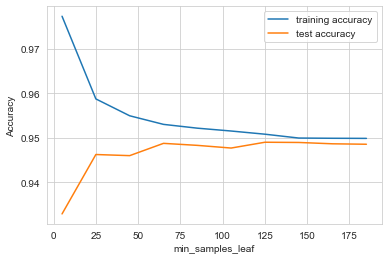

In [77]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


 We can see that at low values of min_samples_leaf, the tree gets a bit overfitted. At values > 100, however, the model becomes more stable and the training and test accuracy start to converge.

#### Tuning min_samples_split
The hyperparameter min_samples_split is the minimum no. of samples required to split an internal node. Its default value is 2, which means that even if a node is having 2 samples it can be furthur divided into leaf nodes.

In [78]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, return_train_score=True,
                   scoring="accuracy")
tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_split': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tr

In [79]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0           2.04          0.23             0.01            0.00   
1           2.31          0.18             0.01            0.00   
2           1.97          0.14             0.01            0.00   
3           1.96          0.15             0.01            0.00   
4           1.95          0.14             0.01            0.00   

  param_min_samples_split                     params  split0_test_score  \
0                       5   {'min_samples_split': 5}               0.93   
1                      25  {'min_samples_split': 25}               0.93   
2                      45  {'min_samples_split': 45}               0.94   
3                      65  {'min_samples_split': 65}               0.94   
4                      85  {'min_samples_split': 85}               0.94   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0               0.93               0.93               0.92  ...   
1               0.93               0.93               0.93  ...   
2               0.93               0.93               0.93  ...   
3               0.94               0.93               0.94  ...   
4               0.94               0.94               0.94  ...   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0             0.93            0.00               10                1.00   
1             0.93            0.00                9                0.98   
2             0.94            0.00                8                0.97   
3             0.94            0.00                7                0.97   
4             0.94            0.00                6                0.96   

   split1_train_score  split2_train_score  split3_train_score  \
0                0.99                1.00                1.00   
1                0.98                0.98                0.98   
2                0.97                0.97                0.97   
3                0.97                0.97                0.97   
4                0.96                0.96                0.96   

   split4_train_score  mean_train_score  std_train_score  
0                1.00              1.00             0.00  
1                0.98              0.98             0.00  
2                0.97              0.97             0.00  
3                0.96              0.97             0.00  
4                0.96              0.96             0.00  

[5 rows x 21 columns]

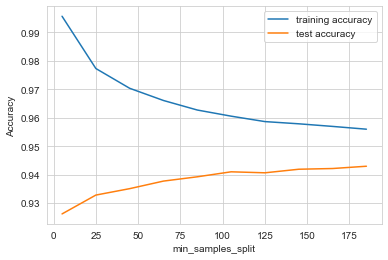

In [80]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

This shows that as you increase the min_samples_split, the tree overfits lesser since the model is less complex.

#### Grid Search to Find Optimal Hyperparameters

We can now use GridSearchCV to find multiple optimal hyperparameters together. Note that this time, we'll also specify the criterion (gini/entropy or IG).

In [81]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1,return_train_score=True)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                      

In [82]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0            0.73          0.08             0.01            0.00   
1            0.66          0.01             0.01            0.00   
2            0.66          0.00             0.01            0.00   
3            0.66          0.01             0.01            0.00   
4            1.05          0.02             0.01            0.00   
5            1.05          0.02             0.01            0.00   
6            0.99          0.02             0.01            0.00   
7            0.99          0.03             0.01            0.00   
8            0.52          0.00             0.01            0.00   
9            0.53          0.01             0.01            0.00   
10           0.52          0.00             0.01            0.00   
11           0.53          0.01             0.01            0.00   
12           0.95          0.01             0.01            0.00   
13           0.95          0.01             0.01            0.00   
14           0.91          0.01             0.01            0.00   
15           0.91          0.01             0.01            0.00   

   param_criterion param_max_depth param_min_samples_leaf  \
0          entropy               5                     50   
1          entropy               5                     50   
2          entropy               5                    100   
3          entropy               5                    100   
4          entropy              10                     50   
5          entropy              10                     50   
6          entropy              10                    100   
7          entropy              10                    100   
8             gini               5                     50   
9             gini               5                     50   
10            gini               5                    100   
11            gini               5                    100   
12            gini              10                     50   
13            gini              10                     50   
14            gini              10                    100   
15            gini              10                    100   

   param_min_samples_split                                             params  \
0                       50  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
1                      100  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
2                       50  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
3                      100  {'criterion': 'entropy', 'max_depth': 5, 'min_...   
4                       50  {'criterion': 'entropy', 'max_depth': 10, 'min...   
5                      100  {'criterion': 'entropy', 'max_depth': 10, 'min...   
6                       50  {'criterion': 'entropy', 'max_depth': 10, 'min...   
7                      100  {'criterion': 'entropy', 'max_depth': 10, 'min...   
8                       50  {'criterion': 'gini', 'max_depth': 5, 'min_sam...   
9                      100  {'criterion': 'gini', 'max_depth': 5, 'min_sam...   
10                      50  {'criterion': 'gini', 'max_depth': 5, 'min_sam...   
11                     100  {'criterion': 'gini', 'max_depth': 5, 'min_sam...   
12                      50  {'criterion': 'gini', 'max_depth': 10, 'min_sa...   
13                     100  {'criterion': 'gini', 'max_depth': 10, 'min_sa...   
14                      50  {'criterion': 'gini', 'max_depth': 10, 'min_sa...   
15                     100  {'criterion': 'gini', 'max_depth': 10, 'min_sa...   

    split0_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0                0.95  ...             0.95            0.00                7   
1                0.95  ...             0.95            0.00                7   
2                0.95  ...             0.95            0.00               10   
3                0.95  ...             0.95            0.00               10   
4                0.94  ...     

In [83]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.9479250200481155
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


#### Running the model with best parameters obtained from grid search.

In [84]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [85]:
# accuracy score
clf_gini.score(X_test,y_test)

0.942820392890552

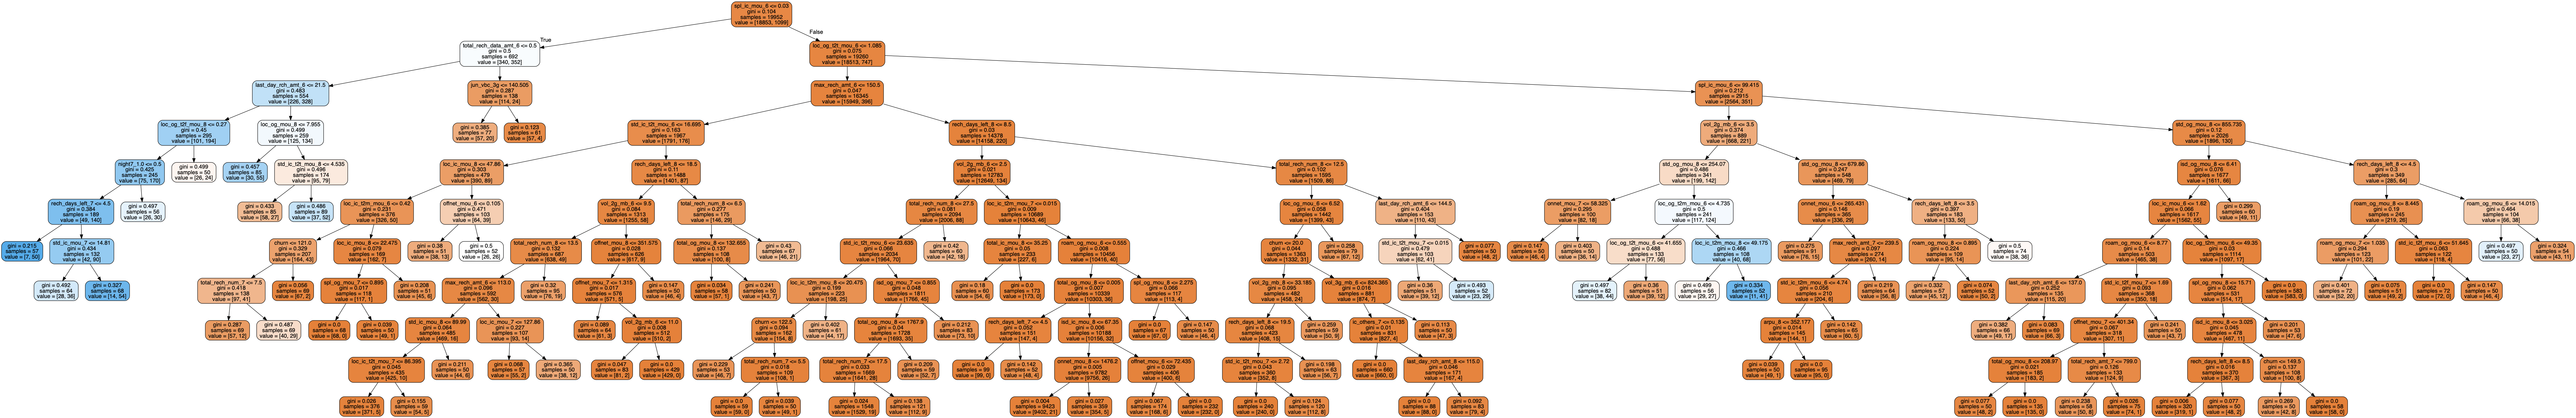

In [86]:
# plotting the tree
dot_data = StringIO()  
export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [87]:
# tree with max_depth = 3
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=3, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)
clf_gini.fit(X_train, y_train)

# score
print(clf_gini.score(X_test,y_test))

0.9478484565014031


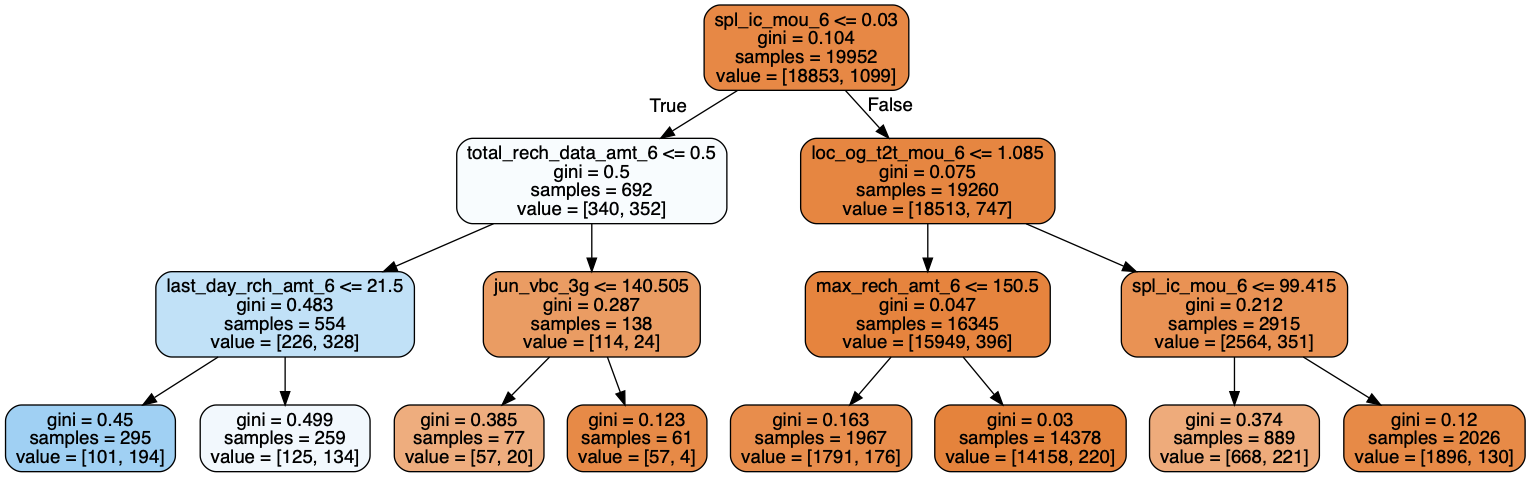

In [88]:
# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(clf_gini, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [89]:
# classification metrics
from sklearn.metrics import classification_report,confusion_matrix
y_pred = clf_gini.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      8055
           1       0.60      0.30      0.40       497

    accuracy                           0.95      8552
   macro avg       0.78      0.64      0.69      8552
weighted avg       0.94      0.95      0.94      8552



In [90]:
# confusion matrix
print(confusion_matrix(y_test,y_pred))

[[7956   99]
 [ 347  150]]


## Observations and Recommendations


Based on the decision tree with the tuned hyperparameters, we can make the following observations and recommendations accordingly. If the customer meets the following criterias, then one is likely to churn 


1. Case 1
    - `spl_ic_mou_6` special calls with less than 0.3 minutes of usage
    - `total_rech_data_amt_6` total data recharge amount less than 0.5 INR
    - `last_day_rch_amt_6` number of days since last recharge less than 21.5 


2. Case 2 
    - `spl_ic_mou_6` special calls with less than 0.3 minutes of usage
    - `total_rech_data_amt_6` total data recharge amount less than 0.5 INR
    - `june_vbc_3g` volume based cost for 3g

3. Case 3
    - `spl_ic_mou_6` special calls with less than 0.3 minutes of usage
    - `loc_og_t2t_mou_6` local outgoing calls less than 6 minutes
    - `max_rech_amt_6` maximum regarche

4. Case 4
    - `spl_ic_mou_6` special calls with less than 0.3 minutes of usage
    - `loc_og_t2t_mou_6` local outgoing calls less than 6 minutes
    - `spl_ic_mou_6` special incoming minutes of usage less than 99 minutes


It is recommended that the marketing team should redirect their efforts towards the prevention of churn of these customers.